# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from skimage import measure
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

import keras
from keras.models import Model
from keras.layers import Dense, Flatten, Conv1D, Conv2D, Input, Conv1DTranspose, Conv2DTranspose, Concatenate, MaxPool1D, Dropout, Reshape, Lambda, InputLayer, LeakyReLU, BatchNormalization
from keras.optimizers import adam_v2
from keras.losses import MeanSquaredError
from keras.metrics import BinaryCrossentropy

## Test GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs available:",len(physical_devices))

GPUs available: 1


# Data preparation

2352 7475


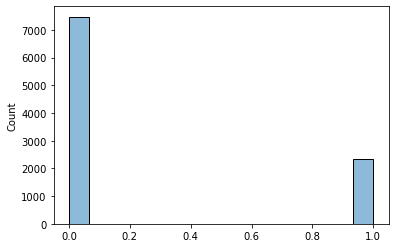

In [4]:
data = np.loadtxt(r'C:\Users\lucas.barbosa\Documents\GitHub\INT\Manufatura Aditiva\Simulacao-GAN\Pipeline\4- Machine_learning\Extraction\data\RTGA\p4\isotropy.csv',delimiter=',')
X = data[:,1:-1]
size = int(np.sqrt(X.shape[1]))
X = X.reshape((X.shape[0],size,size,1))

y = data[:,-1]
y = y.reshape((y.shape[0],1))

scaler = MinMaxScaler()
y = scaler.fit_transform(y).round(10)
cutoff = 0.9
idxs_good = np.where(y>cutoff)[0]
idxs_bad = np.where(y<=cutoff)[0]

y = np.zeros(y.shape)
y[idxs_good] = 1.0
print(len(idxs_good),len(y)-len(idxs_good))
sns.histplot(y,legend=False)

X_good = X[idxs_good]

input_G = 128
output_G = input_D = X.shape[1:]
output_D = 1

# Models definition

## Generator

In [5]:
def setup_G(input_G,output_G,size):
    size = int(size/2)
    in_G = Input(shape=(input_G,))

    # foundation for 7x7 image
    n_nodes = 128 * size * size
    out_G = Dense(n_nodes,activation=LeakyReLU(alpha=0.2))(in_G)
    out_G = Reshape((size, size, 128))(out_G)
    # upsample to 14x14
    out_G = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation=LeakyReLU(alpha=0.2))(out_G)
    out_G = Conv2D(1, (size,size), activation='sigmoid', padding='same')(out_G)


    out_density = Lambda(lambda x:x)(out_G)

    model = Model(name='Generator',inputs=in_G,outputs=[out_G,out_density])

    return model
setup_G(input_G,output_G,size).summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 1)         8193      
_________________________________________________________________
lambda (Lambda)              (None, 16, 16, 1)         0         
Total params: 1,327,233
Trainable params: 1,327,233
Non-trainable params: 0
_______________________________________________

## Discriminator

In [6]:
def style_loss(alpha):
    def custom_loss(y_true,y_pred):
#         y_pred = tf.reshape(y_pred,shape=(y_pred.shape[0],y_pred.shape[1]*y_pred.shape[2]))
#         y_true = tf.reshape(y_true,shape=(y_true.shape[0],y_true.shape[1]*y_true.shape[2]))
        size = y_pred.shape[1]*y_pred.shape[2]
        por_true = K.sum(K.sum(K.sum(y_true,axis=1),axis=1),axis=1)/size
        por_pred = K.sum(K.sum(K.sum(y_pred,axis=1),axis=1),axis=1)/size
        mse = MeanSquaredError()
        return alpha*mse(por_true,por_pred)
    return custom_loss

def setup_D(input_D,alpha):
    in_D = Input(shape=input_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(in_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(out_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Flatten()(out_D)
    out_D = Dense(1, activation='sigmoid')(out_D)

    # compile model
    opt = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)
    
    in_density = Input(shape=input_D)
    out_density = Lambda(lambda x: x)(in_density)

    optimizer = adam_v2.Adam(learning_rate=0.0001, beta_1=0.5)
    model = Model(name='Discriminator',inputs=[in_D,in_density],outputs=[out_D,out_density])

    model.compile(loss=['binary_crossentropy',style_loss(alpha)], optimizer=optimizer, metrics=['accuracy'])
    return model

setup_D(input_D,0.03).summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     640         input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8, 8, 64)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     36928       dropout[0][0]                    
______________________________________________________________________________________

## Setup GAN

In [7]:
def setup_GAN(G_model,D_model,alpha,lr,size):
    optimizer = adam_v2.Adam(learning_rate=lr, beta_1=0.5)
    D_model.trainable = False
    in_G = G_model.input
    out_GAN = D_model(G_model(in_G))
    model = Model(name='GAN',inputs=in_G,outputs=out_GAN)
    model.compile(loss=['binary_crossentropy',style_loss(alpha)], \
               optimizer=optimizer, \
               metrics=['accuracy'])
    return model

alpha = 0.03
lr = 2e-4
setup_GAN(setup_G(input_G,output_G,size),setup_D(input_D,alpha),alpha,lr,size).summary()

Model: "GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
Generator (Functional)          [(None, 16, 16, 1),  1327233     input_4[0][0]                    
__________________________________________________________________________________________________
Discriminator (Functional)      [(None, 1), (None, 1 38593       Generator[0][0]                  
                                                                 Generator[0][1]                  
Total params: 1,365,826
Trainable params: 1,327,233
Non-trainable params: 38,593
__________________________________________________________________________________________________


# Defining auxiliary functions

In [8]:
def generate_fake_samples(G_model, input_G, n_samples):
    # generate points in latent space
    X_input = generate_input_G(input_G, n_samples)
    # predict outputs
    X,_ = G_model.predict(X_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X,y

def generate_input_G(input_G, n_samples):
    # generate points in the latent space
    X_input = np.random.randn(input_G * n_samples)
    # reshape into a batch of inputs for the network
    X_input = X_input.reshape(n_samples, input_G)
    return X_input

def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

>1, 1/36, D_loss=0.699, G_loss=0.690
>1, 2/36, D_loss=0.692, G_loss=0.693
>1, 3/36, D_loss=0.686, G_loss=0.694
>1, 4/36, D_loss=0.679, G_loss=0.694
>1, 5/36, D_loss=0.692, G_loss=0.697
>1, 6/36, D_loss=0.694, G_loss=0.696
>1, 7/36, D_loss=0.701, G_loss=0.699
>1, 8/36, D_loss=0.690, G_loss=0.699
>1, 9/36, D_loss=0.692, G_loss=0.694
>1, 10/36, D_loss=0.699, G_loss=0.699
>1, 11/36, D_loss=0.693, G_loss=0.701
>1, 12/36, D_loss=0.688, G_loss=0.691
>1, 13/36, D_loss=0.692, G_loss=0.701
>1, 14/36, D_loss=0.696, G_loss=0.705
>1, 15/36, D_loss=0.693, G_loss=0.702
>1, 16/36, D_loss=0.690, G_loss=0.690
>1, 17/36, D_loss=0.668, G_loss=0.690
>1, 18/36, D_loss=0.700, G_loss=0.693
>1, 19/36, D_loss=0.676, G_loss=0.692
>1, 20/36, D_loss=0.685, G_loss=0.692
>1, 21/36, D_loss=0.689, G_loss=0.692
>1, 22/36, D_loss=0.692, G_loss=0.690
>1, 23/36, D_loss=0.684, G_loss=0.693
>1, 24/36, D_loss=0.677, G_loss=0.678
>1, 25/36, D_loss=0.670, G_loss=0.697
>1, 26/36, D_loss=0.678, G_loss=0.684
>1, 27/36, D_loss=0.6

>7, 6/36, D_loss=0.655, G_loss=0.767
>7, 7/36, D_loss=0.663, G_loss=0.747
>7, 8/36, D_loss=0.683, G_loss=0.730
>7, 9/36, D_loss=0.685, G_loss=0.718
>7, 10/36, D_loss=0.685, G_loss=0.704
>7, 11/36, D_loss=0.680, G_loss=0.701
>7, 12/36, D_loss=0.675, G_loss=0.701
>7, 13/36, D_loss=0.656, G_loss=0.687
>7, 14/36, D_loss=0.662, G_loss=0.690
>7, 15/36, D_loss=0.664, G_loss=0.681
>7, 16/36, D_loss=0.673, G_loss=0.688
>7, 17/36, D_loss=0.652, G_loss=0.685
>7, 18/36, D_loss=0.644, G_loss=0.685
>7, 19/36, D_loss=0.646, G_loss=0.678
>7, 20/36, D_loss=0.639, G_loss=0.685
>7, 21/36, D_loss=0.639, G_loss=0.679
>7, 22/36, D_loss=0.644, G_loss=0.679
>7, 23/36, D_loss=0.647, G_loss=0.678
>7, 24/36, D_loss=0.645, G_loss=0.688
>7, 25/36, D_loss=0.647, G_loss=0.702
>7, 26/36, D_loss=0.642, G_loss=0.703
>7, 27/36, D_loss=0.638, G_loss=0.696
>7, 28/36, D_loss=0.619, G_loss=0.695
>7, 29/36, D_loss=0.629, G_loss=0.726
>7, 30/36, D_loss=0.622, G_loss=0.725
>7, 31/36, D_loss=0.624, G_loss=0.743
>7, 32/36, D_los

>13, 6/36, D_loss=0.644, G_loss=1.069
>13, 7/36, D_loss=0.640, G_loss=1.115
>13, 8/36, D_loss=0.628, G_loss=1.116
>13, 9/36, D_loss=0.634, G_loss=1.090
>13, 10/36, D_loss=0.642, G_loss=1.090
>13, 11/36, D_loss=0.611, G_loss=1.071
>13, 12/36, D_loss=0.638, G_loss=1.074
>13, 13/36, D_loss=0.626, G_loss=1.010
>13, 14/36, D_loss=0.631, G_loss=1.023
>13, 15/36, D_loss=0.620, G_loss=1.026
>13, 16/36, D_loss=0.633, G_loss=0.996
>13, 17/36, D_loss=0.632, G_loss=0.959
>13, 18/36, D_loss=0.626, G_loss=0.967
>13, 19/36, D_loss=0.624, G_loss=0.946
>13, 20/36, D_loss=0.608, G_loss=0.909
>13, 21/36, D_loss=0.639, G_loss=0.865
>13, 22/36, D_loss=0.644, G_loss=0.882
>13, 23/36, D_loss=0.652, G_loss=0.853
>13, 24/36, D_loss=0.629, G_loss=0.869
>13, 25/36, D_loss=0.637, G_loss=0.835
>13, 26/36, D_loss=0.636, G_loss=0.850
>13, 27/36, D_loss=0.657, G_loss=0.814
>13, 28/36, D_loss=0.649, G_loss=0.830
>13, 29/36, D_loss=0.642, G_loss=0.804
>13, 30/36, D_loss=0.647, G_loss=0.812
>13, 31/36, D_loss=0.648, G_l

>19, 2/36, D_loss=0.575, G_loss=0.837
>19, 3/36, D_loss=0.539, G_loss=0.836
>19, 4/36, D_loss=0.575, G_loss=0.878
>19, 5/36, D_loss=0.525, G_loss=0.844
>19, 6/36, D_loss=0.541, G_loss=0.870
>19, 7/36, D_loss=0.522, G_loss=0.882
>19, 8/36, D_loss=0.515, G_loss=0.873
>19, 9/36, D_loss=0.541, G_loss=0.883
>19, 10/36, D_loss=0.550, G_loss=0.896
>19, 11/36, D_loss=0.530, G_loss=0.928
>19, 12/36, D_loss=0.541, G_loss=0.882
>19, 13/36, D_loss=0.546, G_loss=0.895
>19, 14/36, D_loss=0.535, G_loss=0.901
>19, 15/36, D_loss=0.550, G_loss=0.886
>19, 16/36, D_loss=0.526, G_loss=0.935
>19, 17/36, D_loss=0.534, G_loss=0.929
>19, 18/36, D_loss=0.531, G_loss=0.952
>19, 19/36, D_loss=0.544, G_loss=0.905
>19, 20/36, D_loss=0.521, G_loss=0.955
>19, 21/36, D_loss=0.541, G_loss=0.951
>19, 22/36, D_loss=0.522, G_loss=0.985
>19, 23/36, D_loss=0.479, G_loss=0.982
>19, 24/36, D_loss=0.529, G_loss=0.940
>19, 25/36, D_loss=0.541, G_loss=0.996
>19, 26/36, D_loss=0.545, G_loss=0.964
>19, 27/36, D_loss=0.523, G_loss=

>24, 36/36, D_loss=0.571, G_loss=0.839
>25, 1/36, D_loss=0.582, G_loss=0.879
>25, 2/36, D_loss=0.548, G_loss=0.776
>25, 3/36, D_loss=0.620, G_loss=0.793
>25, 4/36, D_loss=0.630, G_loss=0.779
>25, 5/36, D_loss=0.694, G_loss=0.727
>25, 6/36, D_loss=0.644, G_loss=0.656
>25, 7/36, D_loss=0.640, G_loss=0.661
>25, 8/36, D_loss=0.717, G_loss=0.630
>25, 9/36, D_loss=0.693, G_loss=0.610
>25, 10/36, D_loss=0.767, G_loss=0.576
>25, 11/36, D_loss=0.705, G_loss=0.562
>25, 12/36, D_loss=0.754, G_loss=0.542
>25, 13/36, D_loss=0.765, G_loss=0.543
>25, 14/36, D_loss=0.798, G_loss=0.503
>25, 15/36, D_loss=0.764, G_loss=0.504
>25, 16/36, D_loss=0.748, G_loss=0.520
>25, 17/36, D_loss=0.743, G_loss=0.484
>25, 18/36, D_loss=0.751, G_loss=0.498
>25, 19/36, D_loss=0.736, G_loss=0.491
>25, 20/36, D_loss=0.730, G_loss=0.489
>25, 21/36, D_loss=0.704, G_loss=0.480
>25, 22/36, D_loss=0.708, G_loss=0.512
>25, 23/36, D_loss=0.705, G_loss=0.480
>25, 24/36, D_loss=0.644, G_loss=0.527
>25, 25/36, D_loss=0.662, G_loss=0

>30, 34/36, D_loss=0.503, G_loss=0.862
>30, 35/36, D_loss=0.538, G_loss=0.859
>30, 36/36, D_loss=0.540, G_loss=0.874
>31, 1/36, D_loss=0.561, G_loss=0.868
>31, 2/36, D_loss=0.597, G_loss=0.888
>31, 3/36, D_loss=0.557, G_loss=0.877
>31, 4/36, D_loss=0.609, G_loss=0.866
>31, 5/36, D_loss=0.552, G_loss=0.905
>31, 6/36, D_loss=0.589, G_loss=0.955
>31, 7/36, D_loss=0.583, G_loss=0.942
>31, 8/36, D_loss=0.608, G_loss=0.950
>31, 9/36, D_loss=0.584, G_loss=0.950
>31, 10/36, D_loss=0.620, G_loss=1.027
>31, 11/36, D_loss=0.631, G_loss=1.005
>31, 12/36, D_loss=0.639, G_loss=1.081
>31, 13/36, D_loss=0.670, G_loss=1.036
>31, 14/36, D_loss=0.660, G_loss=1.040
>31, 15/36, D_loss=0.623, G_loss=1.075
>31, 16/36, D_loss=0.596, G_loss=1.051
>31, 17/36, D_loss=0.655, G_loss=1.057
>31, 18/36, D_loss=0.639, G_loss=1.077
>31, 19/36, D_loss=0.657, G_loss=1.097
>31, 20/36, D_loss=0.624, G_loss=1.022
>31, 21/36, D_loss=0.623, G_loss=1.097
>31, 22/36, D_loss=0.635, G_loss=1.188
>31, 23/36, D_loss=0.663, G_loss=1

>36, 32/36, D_loss=0.611, G_loss=1.343
>36, 33/36, D_loss=0.586, G_loss=1.332
>36, 34/36, D_loss=0.565, G_loss=1.334
>36, 35/36, D_loss=0.520, G_loss=1.308
>36, 36/36, D_loss=0.543, G_loss=1.388
>37, 1/36, D_loss=0.560, G_loss=1.364
>37, 2/36, D_loss=0.522, G_loss=1.343
>37, 3/36, D_loss=0.581, G_loss=1.307
>37, 4/36, D_loss=0.536, G_loss=1.437
>37, 5/36, D_loss=0.528, G_loss=1.248
>37, 6/36, D_loss=0.529, G_loss=1.347
>37, 7/36, D_loss=0.521, G_loss=1.402
>37, 8/36, D_loss=0.535, G_loss=1.359
>37, 9/36, D_loss=0.514, G_loss=1.296
>37, 10/36, D_loss=0.512, G_loss=1.372
>37, 11/36, D_loss=0.520, G_loss=1.265
>37, 12/36, D_loss=0.488, G_loss=1.318
>37, 13/36, D_loss=0.504, G_loss=1.293
>37, 14/36, D_loss=0.538, G_loss=1.266
>37, 15/36, D_loss=0.478, G_loss=1.206
>37, 16/36, D_loss=0.524, G_loss=1.337
>37, 17/36, D_loss=0.529, G_loss=1.305
>37, 18/36, D_loss=0.459, G_loss=1.317
>37, 19/36, D_loss=0.467, G_loss=1.285
>37, 20/36, D_loss=0.469, G_loss=1.364
>37, 21/36, D_loss=0.483, G_loss=1

>42, 31/36, D_loss=0.498, G_loss=1.252
>42, 32/36, D_loss=0.474, G_loss=1.279
>42, 33/36, D_loss=0.476, G_loss=1.295
>42, 34/36, D_loss=0.505, G_loss=1.209
>42, 35/36, D_loss=0.505, G_loss=1.232
>42, 36/36, D_loss=0.510, G_loss=1.272
>43, 1/36, D_loss=0.496, G_loss=1.208
>43, 2/36, D_loss=0.536, G_loss=1.231
>43, 3/36, D_loss=0.539, G_loss=1.252
>43, 4/36, D_loss=0.475, G_loss=1.185
>43, 5/36, D_loss=0.458, G_loss=1.236
>43, 6/36, D_loss=0.487, G_loss=1.183
>43, 7/36, D_loss=0.523, G_loss=1.256
>43, 8/36, D_loss=0.515, G_loss=1.235
>43, 9/36, D_loss=0.480, G_loss=1.081
>43, 10/36, D_loss=0.523, G_loss=1.123
>43, 11/36, D_loss=0.479, G_loss=1.168
>43, 12/36, D_loss=0.517, G_loss=1.146
>43, 13/36, D_loss=0.460, G_loss=1.181
>43, 14/36, D_loss=0.490, G_loss=1.132
>43, 15/36, D_loss=0.490, G_loss=1.164
>43, 16/36, D_loss=0.545, G_loss=1.054
>43, 17/36, D_loss=0.509, G_loss=1.067
>43, 18/36, D_loss=0.531, G_loss=0.990
>43, 19/36, D_loss=0.594, G_loss=1.006
>43, 20/36, D_loss=0.548, G_loss=1

>48, 29/36, D_loss=0.428, G_loss=1.244
>48, 30/36, D_loss=0.456, G_loss=1.159
>48, 31/36, D_loss=0.480, G_loss=1.221
>48, 32/36, D_loss=0.476, G_loss=1.112
>48, 33/36, D_loss=0.528, G_loss=1.117
>48, 34/36, D_loss=0.515, G_loss=1.120
>48, 35/36, D_loss=0.466, G_loss=1.067
>48, 36/36, D_loss=0.464, G_loss=1.025
>49, 1/36, D_loss=0.492, G_loss=1.055
>49, 2/36, D_loss=0.537, G_loss=1.042
>49, 3/36, D_loss=0.533, G_loss=0.946
>49, 4/36, D_loss=0.520, G_loss=0.929
>49, 5/36, D_loss=0.546, G_loss=0.948
>49, 6/36, D_loss=0.572, G_loss=0.819
>49, 7/36, D_loss=0.543, G_loss=0.813
>49, 8/36, D_loss=0.564, G_loss=0.828
>49, 9/36, D_loss=0.615, G_loss=0.823
>49, 10/36, D_loss=0.590, G_loss=0.762
>49, 11/36, D_loss=0.634, G_loss=0.719
>49, 12/36, D_loss=0.612, G_loss=0.670
>49, 13/36, D_loss=0.599, G_loss=0.680
>49, 14/36, D_loss=0.627, G_loss=0.662
>49, 15/36, D_loss=0.668, G_loss=0.677
>49, 16/36, D_loss=0.667, G_loss=0.609
>49, 17/36, D_loss=0.698, G_loss=0.631
>49, 18/36, D_loss=0.689, G_loss=0

>54, 25/36, D_loss=0.561, G_loss=0.939
>54, 26/36, D_loss=0.498, G_loss=0.922
>54, 27/36, D_loss=0.583, G_loss=0.936
>54, 28/36, D_loss=0.505, G_loss=0.952
>54, 29/36, D_loss=0.564, G_loss=0.849
>54, 30/36, D_loss=0.610, G_loss=0.943
>54, 31/36, D_loss=0.596, G_loss=0.865
>54, 32/36, D_loss=0.581, G_loss=0.855
>54, 33/36, D_loss=0.615, G_loss=0.730
>54, 34/36, D_loss=0.630, G_loss=0.807
>54, 35/36, D_loss=0.602, G_loss=0.730
>54, 36/36, D_loss=0.636, G_loss=0.754
>55, 1/36, D_loss=0.635, G_loss=0.737
>55, 2/36, D_loss=0.579, G_loss=0.641
>55, 3/36, D_loss=0.669, G_loss=0.664
>55, 4/36, D_loss=0.671, G_loss=0.614
>55, 5/36, D_loss=0.695, G_loss=0.636
>55, 6/36, D_loss=0.649, G_loss=0.570
>55, 7/36, D_loss=0.707, G_loss=0.584
>55, 8/36, D_loss=0.717, G_loss=0.544
>55, 9/36, D_loss=0.766, G_loss=0.528
>55, 10/36, D_loss=0.699, G_loss=0.513
>55, 11/36, D_loss=0.736, G_loss=0.540
>55, 12/36, D_loss=0.727, G_loss=0.511
>55, 13/36, D_loss=0.650, G_loss=0.498
>55, 14/36, D_loss=0.711, G_loss=0

>60, 21/36, D_loss=0.570, G_loss=0.808
>60, 22/36, D_loss=0.568, G_loss=0.898
>60, 23/36, D_loss=0.543, G_loss=0.832
>60, 24/36, D_loss=0.561, G_loss=0.918
>60, 25/36, D_loss=0.664, G_loss=0.744
>60, 26/36, D_loss=0.666, G_loss=0.712
>60, 27/36, D_loss=0.604, G_loss=0.761
>60, 28/36, D_loss=0.656, G_loss=0.599
>60, 29/36, D_loss=0.717, G_loss=0.632
>60, 30/36, D_loss=0.763, G_loss=0.610
>60, 31/36, D_loss=0.792, G_loss=0.611
>60, 32/36, D_loss=0.686, G_loss=0.549
>60, 33/36, D_loss=0.737, G_loss=0.502
>60, 34/36, D_loss=0.753, G_loss=0.469
>60, 35/36, D_loss=0.712, G_loss=0.498
>60, 36/36, D_loss=0.756, G_loss=0.472
>61, 1/36, D_loss=0.783, G_loss=0.485
>61, 2/36, D_loss=0.800, G_loss=0.468
>61, 3/36, D_loss=0.815, G_loss=0.444
>61, 4/36, D_loss=0.796, G_loss=0.459
>61, 5/36, D_loss=0.785, G_loss=0.470
>61, 6/36, D_loss=0.730, G_loss=0.475
>61, 7/36, D_loss=0.756, G_loss=0.432
>61, 8/36, D_loss=0.709, G_loss=0.441
>61, 9/36, D_loss=0.657, G_loss=0.477
>61, 10/36, D_loss=0.668, G_loss=0

>66, 19/36, D_loss=0.640, G_loss=0.616
>66, 20/36, D_loss=0.671, G_loss=0.586
>66, 21/36, D_loss=0.737, G_loss=0.548
>66, 22/36, D_loss=0.726, G_loss=0.563
>66, 23/36, D_loss=0.749, G_loss=0.507
>66, 24/36, D_loss=0.691, G_loss=0.553
>66, 25/36, D_loss=0.721, G_loss=0.552
>66, 26/36, D_loss=0.662, G_loss=0.488
>66, 27/36, D_loss=0.714, G_loss=0.503
>66, 28/36, D_loss=0.674, G_loss=0.540
>66, 29/36, D_loss=0.655, G_loss=0.541
>66, 30/36, D_loss=0.728, G_loss=0.489
>66, 31/36, D_loss=0.656, G_loss=0.502
>66, 32/36, D_loss=0.615, G_loss=0.494
>66, 33/36, D_loss=0.618, G_loss=0.531
>66, 34/36, D_loss=0.665, G_loss=0.518
>66, 35/36, D_loss=0.615, G_loss=0.502
>66, 36/36, D_loss=0.618, G_loss=0.526
>67, 1/36, D_loss=0.561, G_loss=0.567
>67, 2/36, D_loss=0.605, G_loss=0.550
>67, 3/36, D_loss=0.542, G_loss=0.574
>67, 4/36, D_loss=0.523, G_loss=0.573
>67, 5/36, D_loss=0.559, G_loss=0.613
>67, 6/36, D_loss=0.532, G_loss=0.592
>67, 7/36, D_loss=0.516, G_loss=0.679
>67, 8/36, D_loss=0.534, G_loss=

>72, 17/36, D_loss=0.612, G_loss=0.530
>72, 18/36, D_loss=0.610, G_loss=0.552
>72, 19/36, D_loss=0.569, G_loss=0.533
>72, 20/36, D_loss=0.652, G_loss=0.523
>72, 21/36, D_loss=0.559, G_loss=0.594
>72, 22/36, D_loss=0.553, G_loss=0.569
>72, 23/36, D_loss=0.572, G_loss=0.656
>72, 24/36, D_loss=0.506, G_loss=0.683
>72, 25/36, D_loss=0.478, G_loss=0.672
>72, 26/36, D_loss=0.542, G_loss=0.664
>72, 27/36, D_loss=0.490, G_loss=0.696
>72, 28/36, D_loss=0.482, G_loss=0.693
>72, 29/36, D_loss=0.457, G_loss=0.716
>72, 30/36, D_loss=0.423, G_loss=0.758
>72, 31/36, D_loss=0.448, G_loss=0.742
>72, 32/36, D_loss=0.433, G_loss=0.785
>72, 33/36, D_loss=0.426, G_loss=0.793
>72, 34/36, D_loss=0.427, G_loss=0.779
>72, 35/36, D_loss=0.400, G_loss=0.827
>72, 36/36, D_loss=0.368, G_loss=0.860
>73, 1/36, D_loss=0.367, G_loss=0.907
>73, 2/36, D_loss=0.370, G_loss=0.930
>73, 3/36, D_loss=0.365, G_loss=0.901
>73, 4/36, D_loss=0.356, G_loss=0.879
>73, 5/36, D_loss=0.338, G_loss=0.992
>73, 6/36, D_loss=0.381, G_los

>78, 14/36, D_loss=0.356, G_loss=0.897
>78, 15/36, D_loss=0.373, G_loss=0.948
>78, 16/36, D_loss=0.391, G_loss=0.909
>78, 17/36, D_loss=0.372, G_loss=0.959
>78, 18/36, D_loss=0.376, G_loss=0.968
>78, 19/36, D_loss=0.326, G_loss=1.062
>78, 20/36, D_loss=0.351, G_loss=1.043
>78, 21/36, D_loss=0.311, G_loss=1.018
>78, 22/36, D_loss=0.334, G_loss=0.970
>78, 23/36, D_loss=0.346, G_loss=1.030
>78, 24/36, D_loss=0.364, G_loss=1.023
>78, 25/36, D_loss=0.346, G_loss=1.008
>78, 26/36, D_loss=0.337, G_loss=0.988
>78, 27/36, D_loss=0.384, G_loss=1.015
>78, 28/36, D_loss=0.360, G_loss=1.017
>78, 29/36, D_loss=0.387, G_loss=0.974
>78, 30/36, D_loss=0.372, G_loss=0.898
>78, 31/36, D_loss=0.436, G_loss=0.982
>78, 32/36, D_loss=0.466, G_loss=0.898
>78, 33/36, D_loss=0.529, G_loss=0.936
>78, 34/36, D_loss=0.484, G_loss=0.967
>78, 35/36, D_loss=0.551, G_loss=0.873
>78, 36/36, D_loss=0.518, G_loss=0.963
>79, 1/36, D_loss=0.514, G_loss=1.029
>79, 2/36, D_loss=0.581, G_loss=0.919
>79, 3/36, D_loss=0.661, G_

>84, 13/36, D_loss=0.753, G_loss=0.956
>84, 14/36, D_loss=0.780, G_loss=1.163
>84, 15/36, D_loss=0.796, G_loss=1.111
>84, 16/36, D_loss=0.691, G_loss=1.098
>84, 17/36, D_loss=0.774, G_loss=0.983
>84, 18/36, D_loss=0.835, G_loss=1.003
>84, 19/36, D_loss=0.768, G_loss=0.969
>84, 20/36, D_loss=0.721, G_loss=0.924
>84, 21/36, D_loss=0.732, G_loss=1.030
>84, 22/36, D_loss=0.710, G_loss=1.041
>84, 23/36, D_loss=0.681, G_loss=0.979
>84, 24/36, D_loss=0.700, G_loss=1.196
>84, 25/36, D_loss=0.728, G_loss=1.153
>84, 26/36, D_loss=0.696, G_loss=1.186
>84, 27/36, D_loss=0.681, G_loss=1.144
>84, 28/36, D_loss=0.679, G_loss=1.159
>84, 29/36, D_loss=0.662, G_loss=1.232
>84, 30/36, D_loss=0.702, G_loss=1.161
>84, 31/36, D_loss=0.629, G_loss=1.132
>84, 32/36, D_loss=0.655, G_loss=1.162
>84, 33/36, D_loss=0.751, G_loss=1.006
>84, 34/36, D_loss=0.642, G_loss=1.007
>84, 35/36, D_loss=0.609, G_loss=1.221
>84, 36/36, D_loss=0.625, G_loss=1.190
>85, 1/36, D_loss=0.556, G_loss=1.278
>85, 2/36, D_loss=0.596, G

>90, 12/36, D_loss=0.567, G_loss=1.021
>90, 13/36, D_loss=0.599, G_loss=1.073
>90, 14/36, D_loss=0.573, G_loss=0.933
>90, 15/36, D_loss=0.576, G_loss=1.026
>90, 16/36, D_loss=0.489, G_loss=1.102
>90, 17/36, D_loss=0.577, G_loss=1.128
>90, 18/36, D_loss=0.574, G_loss=1.105
>90, 19/36, D_loss=0.540, G_loss=1.093
>90, 20/36, D_loss=0.604, G_loss=1.035
>90, 21/36, D_loss=0.580, G_loss=1.013
>90, 22/36, D_loss=0.594, G_loss=1.105
>90, 23/36, D_loss=0.613, G_loss=1.080
>90, 24/36, D_loss=0.653, G_loss=0.990
>90, 25/36, D_loss=0.600, G_loss=0.936
>90, 26/36, D_loss=0.598, G_loss=0.932
>90, 27/36, D_loss=0.565, G_loss=0.990
>90, 28/36, D_loss=0.629, G_loss=0.949
>90, 29/36, D_loss=0.616, G_loss=0.786
>90, 30/36, D_loss=0.597, G_loss=0.849
>90, 31/36, D_loss=0.662, G_loss=0.899
>90, 32/36, D_loss=0.580, G_loss=0.885
>90, 33/36, D_loss=0.500, G_loss=0.866
>90, 34/36, D_loss=0.649, G_loss=0.805
>90, 35/36, D_loss=0.580, G_loss=0.909
>90, 36/36, D_loss=0.696, G_loss=0.783
>91, 1/36, D_loss=0.635, 

>96, 10/36, D_loss=0.616, G_loss=0.771
>96, 11/36, D_loss=0.637, G_loss=0.819
>96, 12/36, D_loss=0.711, G_loss=0.772
>96, 13/36, D_loss=0.638, G_loss=0.761
>96, 14/36, D_loss=0.689, G_loss=0.745
>96, 15/36, D_loss=0.599, G_loss=0.778
>96, 16/36, D_loss=0.614, G_loss=0.817
>96, 17/36, D_loss=0.651, G_loss=0.828
>96, 18/36, D_loss=0.619, G_loss=0.811
>96, 19/36, D_loss=0.687, G_loss=0.905
>96, 20/36, D_loss=0.715, G_loss=0.834
>96, 21/36, D_loss=0.659, G_loss=0.839
>96, 22/36, D_loss=0.607, G_loss=0.918
>96, 23/36, D_loss=0.692, G_loss=0.872
>96, 24/36, D_loss=0.650, G_loss=0.903
>96, 25/36, D_loss=0.671, G_loss=0.823
>96, 26/36, D_loss=0.674, G_loss=0.933
>96, 27/36, D_loss=0.636, G_loss=0.780
>96, 28/36, D_loss=0.670, G_loss=0.844
>96, 29/36, D_loss=0.672, G_loss=0.792
>96, 30/36, D_loss=0.673, G_loss=0.809
>96, 31/36, D_loss=0.655, G_loss=0.836
>96, 32/36, D_loss=0.646, G_loss=0.814
>96, 33/36, D_loss=0.702, G_loss=0.901
>96, 34/36, D_loss=0.657, G_loss=0.921
>96, 35/36, D_loss=0.696,

>102, 5/36, D_loss=0.642, G_loss=0.829
>102, 6/36, D_loss=0.597, G_loss=0.831
>102, 7/36, D_loss=0.685, G_loss=0.785
>102, 8/36, D_loss=0.639, G_loss=0.835
>102, 9/36, D_loss=0.684, G_loss=0.864
>102, 10/36, D_loss=0.698, G_loss=0.826
>102, 11/36, D_loss=0.721, G_loss=0.804
>102, 12/36, D_loss=0.632, G_loss=0.844
>102, 13/36, D_loss=0.672, G_loss=0.864
>102, 14/36, D_loss=0.637, G_loss=0.835
>102, 15/36, D_loss=0.672, G_loss=0.854
>102, 16/36, D_loss=0.651, G_loss=0.746
>102, 17/36, D_loss=0.680, G_loss=0.661
>102, 18/36, D_loss=0.630, G_loss=0.752
>102, 19/36, D_loss=0.710, G_loss=0.788
>102, 20/36, D_loss=0.667, G_loss=0.790
>102, 21/36, D_loss=0.598, G_loss=0.848
>102, 22/36, D_loss=0.608, G_loss=0.816
>102, 23/36, D_loss=0.697, G_loss=0.853
>102, 24/36, D_loss=0.660, G_loss=0.830
>102, 25/36, D_loss=0.585, G_loss=0.846
>102, 26/36, D_loss=0.706, G_loss=0.808
>102, 27/36, D_loss=0.684, G_loss=0.810
>102, 28/36, D_loss=0.675, G_loss=0.735
>102, 29/36, D_loss=0.651, G_loss=0.713
>102,

>107, 34/36, D_loss=0.695, G_loss=0.826
>107, 35/36, D_loss=0.651, G_loss=0.781
>107, 36/36, D_loss=0.632, G_loss=0.801
>108, 1/36, D_loss=0.551, G_loss=0.832
>108, 2/36, D_loss=0.635, G_loss=0.817
>108, 3/36, D_loss=0.609, G_loss=0.861
>108, 4/36, D_loss=0.645, G_loss=0.898
>108, 5/36, D_loss=0.662, G_loss=0.871
>108, 6/36, D_loss=0.602, G_loss=0.880
>108, 7/36, D_loss=0.634, G_loss=0.834
>108, 8/36, D_loss=0.610, G_loss=0.825
>108, 9/36, D_loss=0.660, G_loss=0.794
>108, 10/36, D_loss=0.632, G_loss=0.814
>108, 11/36, D_loss=0.665, G_loss=0.753
>108, 12/36, D_loss=0.645, G_loss=0.853
>108, 13/36, D_loss=0.637, G_loss=0.859
>108, 14/36, D_loss=0.621, G_loss=0.794
>108, 15/36, D_loss=0.656, G_loss=0.735
>108, 16/36, D_loss=0.634, G_loss=0.782
>108, 17/36, D_loss=0.679, G_loss=0.795
>108, 18/36, D_loss=0.652, G_loss=0.870
>108, 19/36, D_loss=0.657, G_loss=0.836
>108, 20/36, D_loss=0.623, G_loss=0.823
>108, 21/36, D_loss=0.645, G_loss=0.806
>108, 22/36, D_loss=0.624, G_loss=0.798
>108, 23/

>113, 28/36, D_loss=0.659, G_loss=0.746
>113, 29/36, D_loss=0.623, G_loss=0.756
>113, 30/36, D_loss=0.688, G_loss=0.877
>113, 31/36, D_loss=0.606, G_loss=0.848
>113, 32/36, D_loss=0.676, G_loss=0.845
>113, 33/36, D_loss=0.614, G_loss=0.829
>113, 34/36, D_loss=0.621, G_loss=0.814
>113, 35/36, D_loss=0.692, G_loss=0.800
>113, 36/36, D_loss=0.673, G_loss=0.838
>114, 1/36, D_loss=0.620, G_loss=0.801
>114, 2/36, D_loss=0.575, G_loss=0.875
>114, 3/36, D_loss=0.616, G_loss=0.776
>114, 4/36, D_loss=0.630, G_loss=0.786
>114, 5/36, D_loss=0.661, G_loss=0.792
>114, 6/36, D_loss=0.619, G_loss=0.797
>114, 7/36, D_loss=0.675, G_loss=0.837
>114, 8/36, D_loss=0.658, G_loss=0.825
>114, 9/36, D_loss=0.631, G_loss=0.845
>114, 10/36, D_loss=0.627, G_loss=0.804
>114, 11/36, D_loss=0.629, G_loss=0.835
>114, 12/36, D_loss=0.612, G_loss=0.834
>114, 13/36, D_loss=0.639, G_loss=0.777
>114, 14/36, D_loss=0.616, G_loss=0.745
>114, 15/36, D_loss=0.637, G_loss=0.814
>114, 16/36, D_loss=0.647, G_loss=0.845
>114, 17/

>119, 21/36, D_loss=0.643, G_loss=0.843
>119, 22/36, D_loss=0.614, G_loss=0.852
>119, 23/36, D_loss=0.626, G_loss=0.844
>119, 24/36, D_loss=0.637, G_loss=0.818
>119, 25/36, D_loss=0.659, G_loss=0.748
>119, 26/36, D_loss=0.596, G_loss=0.822
>119, 27/36, D_loss=0.589, G_loss=0.799
>119, 28/36, D_loss=0.616, G_loss=0.747
>119, 29/36, D_loss=0.611, G_loss=0.753
>119, 30/36, D_loss=0.596, G_loss=0.797
>119, 31/36, D_loss=0.658, G_loss=0.837
>119, 32/36, D_loss=0.609, G_loss=0.786
>119, 33/36, D_loss=0.631, G_loss=0.796
>119, 34/36, D_loss=0.673, G_loss=0.842
>119, 35/36, D_loss=0.628, G_loss=0.816
>119, 36/36, D_loss=0.626, G_loss=0.783
>120, 1/36, D_loss=0.653, G_loss=0.835
>120, 2/36, D_loss=0.653, G_loss=0.833
>120, 3/36, D_loss=0.634, G_loss=0.854
>120, 4/36, D_loss=0.597, G_loss=0.786
>120, 5/36, D_loss=0.652, G_loss=0.812
>120, 6/36, D_loss=0.651, G_loss=0.890
>120, 7/36, D_loss=0.640, G_loss=0.844
>120, 8/36, D_loss=0.609, G_loss=0.901
>120, 9/36, D_loss=0.636, G_loss=0.820
>120, 10/

>125, 13/36, D_loss=0.596, G_loss=0.857
>125, 14/36, D_loss=0.618, G_loss=0.813
>125, 15/36, D_loss=0.590, G_loss=0.878
>125, 16/36, D_loss=0.608, G_loss=0.855
>125, 17/36, D_loss=0.574, G_loss=0.912
>125, 18/36, D_loss=0.553, G_loss=0.839
>125, 19/36, D_loss=0.578, G_loss=0.876
>125, 20/36, D_loss=0.628, G_loss=0.840
>125, 21/36, D_loss=0.598, G_loss=0.848
>125, 22/36, D_loss=0.577, G_loss=0.774
>125, 23/36, D_loss=0.602, G_loss=0.831
>125, 24/36, D_loss=0.561, G_loss=0.897
>125, 25/36, D_loss=0.573, G_loss=0.935
>125, 26/36, D_loss=0.551, G_loss=0.889
>125, 27/36, D_loss=0.575, G_loss=0.893
>125, 28/36, D_loss=0.634, G_loss=0.896
>125, 29/36, D_loss=0.642, G_loss=0.881
>125, 30/36, D_loss=0.594, G_loss=0.936
>125, 31/36, D_loss=0.581, G_loss=0.907
>125, 32/36, D_loss=0.595, G_loss=0.963
>125, 33/36, D_loss=0.616, G_loss=0.861
>125, 34/36, D_loss=0.594, G_loss=0.851
>125, 35/36, D_loss=0.575, G_loss=0.854
>125, 36/36, D_loss=0.585, G_loss=0.893
>126, 1/36, D_loss=0.567, G_loss=0.813
>

>131, 4/36, D_loss=0.615, G_loss=0.805
>131, 5/36, D_loss=0.693, G_loss=0.820
>131, 6/36, D_loss=0.643, G_loss=0.744
>131, 7/36, D_loss=0.720, G_loss=0.740
>131, 8/36, D_loss=0.731, G_loss=0.701
>131, 9/36, D_loss=0.637, G_loss=0.735
>131, 10/36, D_loss=0.656, G_loss=0.741
>131, 11/36, D_loss=0.624, G_loss=0.823
>131, 12/36, D_loss=0.678, G_loss=0.845
>131, 13/36, D_loss=0.661, G_loss=0.721
>131, 14/36, D_loss=0.683, G_loss=0.770
>131, 15/36, D_loss=0.647, G_loss=0.808
>131, 16/36, D_loss=0.650, G_loss=0.847
>131, 17/36, D_loss=0.650, G_loss=0.824
>131, 18/36, D_loss=0.642, G_loss=0.782
>131, 19/36, D_loss=0.609, G_loss=0.849
>131, 20/36, D_loss=0.643, G_loss=0.800
>131, 21/36, D_loss=0.615, G_loss=0.860
>131, 22/36, D_loss=0.601, G_loss=0.842
>131, 23/36, D_loss=0.603, G_loss=0.851
>131, 24/36, D_loss=0.638, G_loss=0.836
>131, 25/36, D_loss=0.572, G_loss=0.850
>131, 26/36, D_loss=0.596, G_loss=0.882
>131, 27/36, D_loss=0.667, G_loss=0.836
>131, 28/36, D_loss=0.646, G_loss=0.816
>131, 

>136, 32/36, D_loss=0.692, G_loss=0.785
>136, 33/36, D_loss=0.629, G_loss=0.775
>136, 34/36, D_loss=0.639, G_loss=0.809
>136, 35/36, D_loss=0.632, G_loss=0.781
>136, 36/36, D_loss=0.634, G_loss=0.821
>137, 1/36, D_loss=0.680, G_loss=0.823
>137, 2/36, D_loss=0.652, G_loss=0.885
>137, 3/36, D_loss=0.655, G_loss=0.849
>137, 4/36, D_loss=0.600, G_loss=0.891
>137, 5/36, D_loss=0.637, G_loss=0.819
>137, 6/36, D_loss=0.648, G_loss=0.918
>137, 7/36, D_loss=0.665, G_loss=0.890
>137, 8/36, D_loss=0.633, G_loss=0.884
>137, 9/36, D_loss=0.604, G_loss=0.955
>137, 10/36, D_loss=0.614, G_loss=0.959
>137, 11/36, D_loss=0.593, G_loss=0.869
>137, 12/36, D_loss=0.688, G_loss=0.924
>137, 13/36, D_loss=0.584, G_loss=0.840
>137, 14/36, D_loss=0.605, G_loss=0.905
>137, 15/36, D_loss=0.561, G_loss=0.882
>137, 16/36, D_loss=0.616, G_loss=0.892
>137, 17/36, D_loss=0.547, G_loss=0.926
>137, 18/36, D_loss=0.548, G_loss=0.893
>137, 19/36, D_loss=0.599, G_loss=0.902
>137, 20/36, D_loss=0.580, G_loss=0.877
>137, 21/

>142, 23/36, D_loss=0.477, G_loss=0.973
>142, 24/36, D_loss=0.520, G_loss=1.111
>142, 25/36, D_loss=0.516, G_loss=1.085
>142, 26/36, D_loss=0.514, G_loss=1.136
>142, 27/36, D_loss=0.538, G_loss=1.023
>142, 28/36, D_loss=0.540, G_loss=1.056
>142, 29/36, D_loss=0.515, G_loss=0.991
>142, 30/36, D_loss=0.565, G_loss=0.982
>142, 31/36, D_loss=0.537, G_loss=1.024
>142, 32/36, D_loss=0.573, G_loss=0.975
>142, 33/36, D_loss=0.527, G_loss=0.984
>142, 34/36, D_loss=0.590, G_loss=0.970
>142, 35/36, D_loss=0.532, G_loss=0.994
>142, 36/36, D_loss=0.547, G_loss=0.907
>143, 1/36, D_loss=0.497, G_loss=0.938
>143, 2/36, D_loss=0.565, G_loss=0.881
>143, 3/36, D_loss=0.499, G_loss=0.922
>143, 4/36, D_loss=0.563, G_loss=1.044
>143, 5/36, D_loss=0.621, G_loss=0.989
>143, 6/36, D_loss=0.632, G_loss=1.098
>143, 7/36, D_loss=0.526, G_loss=0.917
>143, 8/36, D_loss=0.595, G_loss=0.879
>143, 9/36, D_loss=0.547, G_loss=0.909
>143, 10/36, D_loss=0.617, G_loss=0.874
>143, 11/36, D_loss=0.572, G_loss=0.931
>143, 12/

>148, 17/36, D_loss=0.547, G_loss=0.893
>148, 18/36, D_loss=0.565, G_loss=0.982
>148, 19/36, D_loss=0.531, G_loss=0.970
>148, 20/36, D_loss=0.543, G_loss=1.020
>148, 21/36, D_loss=0.521, G_loss=0.941
>148, 22/36, D_loss=0.557, G_loss=0.841
>148, 23/36, D_loss=0.615, G_loss=0.930
>148, 24/36, D_loss=0.554, G_loss=0.900
>148, 25/36, D_loss=0.588, G_loss=0.932
>148, 26/36, D_loss=0.547, G_loss=0.944
>148, 27/36, D_loss=0.551, G_loss=0.976
>148, 28/36, D_loss=0.580, G_loss=0.989
>148, 29/36, D_loss=0.545, G_loss=1.003
>148, 30/36, D_loss=0.609, G_loss=0.925
>148, 31/36, D_loss=0.551, G_loss=0.909
>148, 32/36, D_loss=0.540, G_loss=0.871
>148, 33/36, D_loss=0.569, G_loss=0.930
>148, 34/36, D_loss=0.569, G_loss=1.064
>148, 35/36, D_loss=0.534, G_loss=0.883
>148, 36/36, D_loss=0.557, G_loss=0.936
>149, 1/36, D_loss=0.599, G_loss=0.941
>149, 2/36, D_loss=0.552, G_loss=0.938
>149, 3/36, D_loss=0.543, G_loss=0.957
>149, 4/36, D_loss=0.526, G_loss=0.913
>149, 5/36, D_loss=0.559, G_loss=0.877
>149,

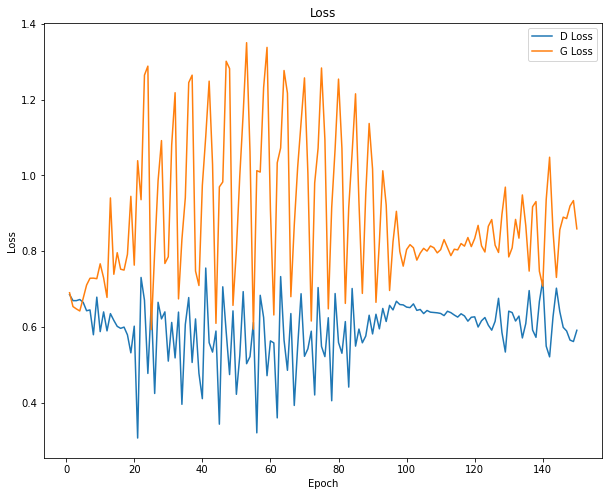

In [9]:
batch_size = 64
num_epochs = 150

alpha = 1e-2
lr = 1e-4
porosity = 0.5

G = setup_G(input_G,output_G,size)
D = setup_D(input_D,alpha)
GAN = setup_GAN(G,D,alpha,lr,size)

def train(G_model,D_model,GAN_model,alpha,lr,porosity,batch_size,num_epochs,plot=False):
    batch_per_epoch = int(X_good.shape[0] /batch_size)
    half_batch = int(batch_size/2)

    G_losses = []
    D_losses = []

    for i in range(num_epochs):
        G_losses_epoch = []
        D_losses_epoch = []
        for j in range(batch_per_epoch):
            X_real,y_real = generate_real_samples(X_good,half_batch)
            X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch)            

            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
        
            D_loss = D_model.train_on_batch(x=[X,X], y=[y,porosity*np.ones(X.shape)])
            D_loss = D_loss[0]
            D_losses_epoch.append(D_loss)
            
            X_GAN = generate_input_G(input_G, batch_size)
            y_GAN = np.ones((batch_size, 1))
            G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape)])
            G_loss = G_loss[0]
            G_losses_epoch.append(G_loss)

            print('>%d, %d/%d, D_loss=%.3f, G_loss=%.3f' % (i+1, j+1, batch_per_epoch,  D_loss, G_loss))
        
        G_losses.append(G_losses_epoch)
        D_losses.append(D_losses_epoch)
        
        if i == 95:
            G_best = G_model

    G_losses = np.array(G_losses)
    D_losses = np.array(D_losses)

    if plot:
        fig = plt.figure()
        fig.set_size_inches((10,8)) 
        plt.plot(list(range(1,num_epochs+1)),np.mean(D_losses,axis=1),label='D Loss')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.plot(list(range(1,num_epochs+1)),np.mean(G_losses,axis=1),label='G Loss')
        plt.legend()
        plt.show()
        
    return G_best

G_best = train(G,D,GAN,alpha,lr,porosity,batch_size,num_epochs,True)


# Training GAN

# Test

6.476


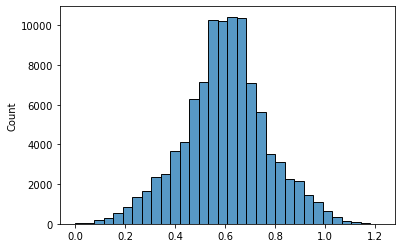

In [11]:
# G = keras.models.load_model("""C:/Users/lucas.barbosa/Documents/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/4- Machine_learning/GAN/models/isotropy_epoch_100_loss_0.7585.h5""")
test_size = 100000
X_test = generate_input_G(input_G,test_size)

generated_geoms,_ = G_best.predict(X_test)

porosities =  []
pors = []

for generated_geom in generated_geoms:
    p = generated_geom.ravel().round().sum()/196
    if p <= 0.52 and p >= 0.48:
        pors.append(p)
    porosities.append(p)

sns.histplot(porosities,bins=32);
print(100*len(pors)/len(porosities))

## Evaluate `Generator`

Score: 0.74 Porosity: 0.43


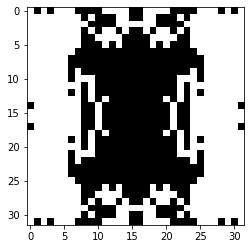

Score: 0.74 Porosity: 0.53


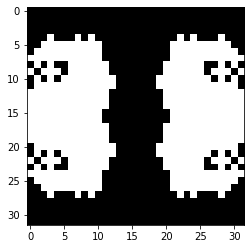

Score: 0.74 Porosity: 0.54


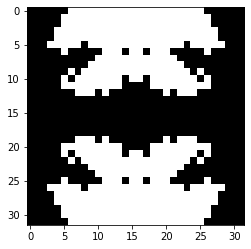

Score: 0.75 Porosity: 0.52


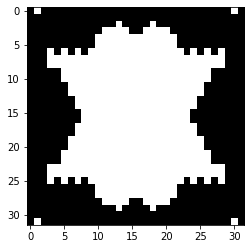

Score: 0.75 Porosity: 0.48


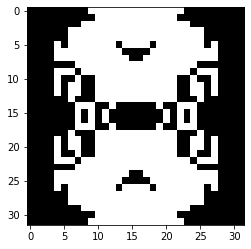

Score: 0.75 Porosity: 0.50


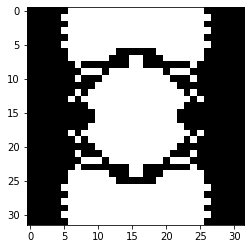

Score: 0.75 Porosity: 0.54


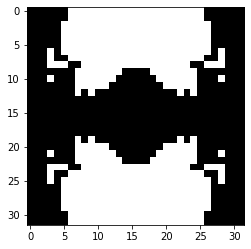

Score: 0.75 Porosity: 0.53


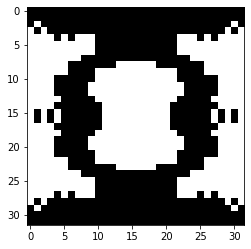

Score: 0.75 Porosity: 0.54


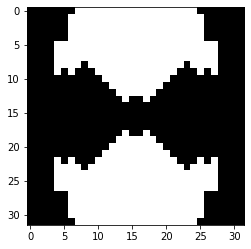

Score: 0.75 Porosity: 0.53


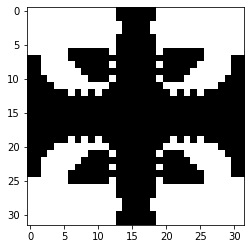

Score: 0.75 Porosity: 0.47


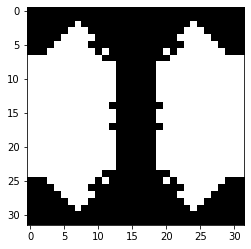

Score: 0.76 Porosity: 0.42


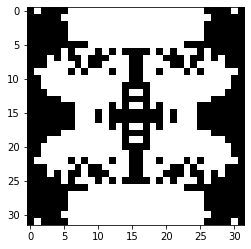

Score: 0.76 Porosity: 0.37


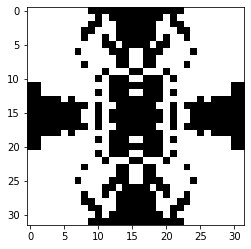

Score: 0.76 Porosity: 0.45


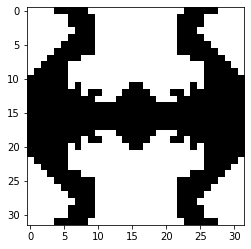

Score: 0.77 Porosity: 0.48


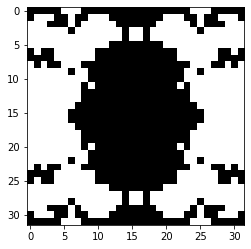

Score: 0.77 Porosity: 0.47


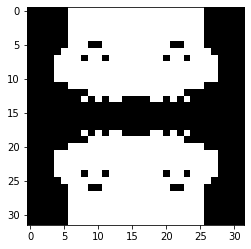

Score: 0.78 Porosity: 0.46


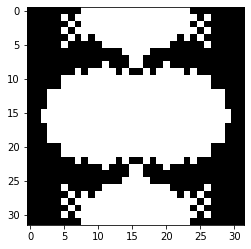

Score: 0.79 Porosity: 0.42


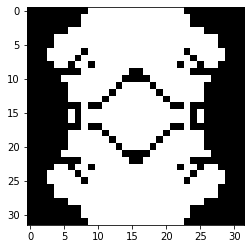

Score: 0.79 Porosity: 0.40


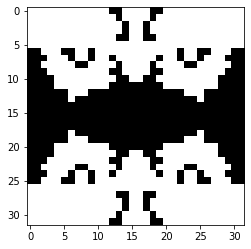

Score: 0.82 Porosity: 0.36


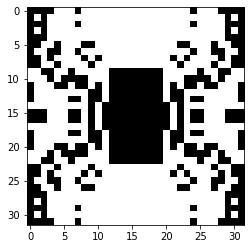

In [15]:
test_size = 100000
X_test = generate_input_G(input_G,test_size)

generated_geoms,_ = G.predict(X_test)

# Filter per porosity
def porosity_match(geoms,porosity,tol):
    geoms_ = []
    passed = 0
    for i in range(geoms.shape[0]):
        g =geoms[i,:,:,0]
        size = g.shape[0]
        g = g.reshape((size*size,))
        p = np.sum(g)/(size*size)
        if p >= (1.0-tol)*porosity and p <= (1.0+tol)*porosity:
            geoms_.append(g.reshape((size,size)))
            passed += 1
    return np.array(geoms_).reshape((passed,size,size,1))

def create_unit(element,size,simmetry):
  if simmetry == 'p4':
    unit_size = 2*size
    fold_size = np.random.choice(4,1)[0]
    unit = np.ones((unit_size,unit_size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        i_ = i+size*(fold_size//2)
        j_ = j+size*(fold_size%2)
        unit[i_,j_] = el
        for k in [i_,2*size-1-i_]:
          for l in [j_,2*size-1-j_]:
            unit[k,l] = el
    
  return unit

def check_geometry(geometry,tol,size,simmetry):
  unit = create_unit(geometry,size,simmetry)
  unit_size = 2*size
  labels = measure.label(unit,connectivity=1)
  main_label = 0
  main_label_count = 0
  for label in range(1,len(np.unique(labels))):
    label_count = np.where(labels==label)[0].shape[0]
    if label_count > main_label_count:
      main_label = label
      main_label_count = label_count

  if np.where(labels==0)[0].shape[0]+np.where(labels==main_label)[0].shape[0] >(1.0-tol)*unit_size*unit_size:
    for label in range(1,len(np.unique(labels))):
      if label not in [0,main_label]:
        unit[np.where(labels==label)] = 0.

    if unit[0,:].sum() > 0 and unit[:,0].sum() > 0:
      return True, unit[:size,:size]

    else:
      return False,unit

  else:
    return False, unit

porosity=0.5
tol = 0.1
simmetry = 'p4'
geometries = porosity_match(generated_geoms,porosity,tol)
size = geometries.shape[1]
geometries_ = []

for i in range(geometries.shape[0]):
  geom = geometries[i].reshape((size,size))
  passed,geom_ = check_geometry(geom,tol,size,simmetry)
  if passed:
    geometries_.append(geom_)

geometries = np.array(geometries_).reshape((len(geometries_),size,size,1))
# Round pixels
geometries = geometries.round()

# Get scores
top = 20
scores = D.predict([geometries,geometries])[0]
top_idxs = scores[:,0].argsort()[-top:]

# Add solid boundary
geometries_expanded = []
for i in range(geometries.shape[0]):
    geom = geometries[i]    
    geometries_expanded.append(geom)

geometries = np.array(geometries_expanded).reshape((geometries.shape[0],geometries.shape[1],geometries.shape[2],geometries.shape[3]))

for top_idx in top_idxs:
    geom = geometries[top_idx]
    unit = create_unit(geom.reshape((size,size)),size,simmetry)
    print("Score: %.2f Porosity: %.2f"%(scores[top_idx,0],geom.ravel().sum()/(size*size)))
    plt.imshow(unit,cmap="Greys")
    plt.show()

# sns.histplot(np.sum(generated_geoms.round().reshape((test_size,int(size*size))),axis=-1)/int(size*size),bins=32);